# Retrieval Agent

A notebook to explain how the retrieval Agent works

In [4]:
from contextlib import contextmanager
from dataclasses import dataclass, field
from typing import (Generator, Annotated, Any, Literal, Optional, Sequence,
                    Union)
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from langchain_core.embeddings import Embeddings
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_chroma import Chroma

In [5]:
VECTORSTORE_DIR = "../src/user_data/vectorstore/"

In [6]:
def context_search(query: str) -> str:
    """
    This function sends a request to a knowledge base and returns the
    k closest chunks of text.
    Args:
        - query : the request (str)
    Returns:
        - context : the retrieved documents (str)
    """
    
    docs=retriever.invoke(input=query)
    from ..src.utils.utils import format_docs
    context = format_docs(docs=docs)
    return context

tools = [context_search]

In [7]:
embeddings = OllamaEmbeddings(model="nomic-embed-text", num_ctx=4096) 
model = ChatOllama(model="deepseek-r1",
                   temperature=0,
                   num_ctx=8192).bind_tools(tools)
# Context window size, default 2048 seems to trigger "decode: cannot decode
# batches with this context (use llama_encode() instead)" in Ollama

In [8]:
# Found in src/core/retrieval.py

_COLLECTION = "HOMER"
_COLLECTION_METADATA = {"hnsw:space": "cosine"}

vector_store = Chroma(
  collection_name = _COLLECTION,
  collection_metadata= _COLLECTION_METADATA,
  embedding_function = embeddings,
  persist_directory = VECTORSTORE_DIR,  # Where to save data locally
)

retriever = vector_store.as_retriever(
  )

## States

The state will be passed down each nodes and updated. The input state can be different from the output state.

In [9]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

## Nodes

### Tool node
The tool node is a function called "context_search" which will perform a 
search in a chromaDB vectorstore. It will be called by the main model node.

In [10]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [11]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [12]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

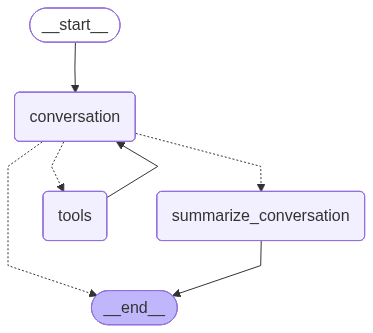

In [19]:
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))